# Discovery of Non-Linear Double Pendulum Dynamics using SODAs: SVD analysis

In [4]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


## Loading data

In [15]:

# Loading pendulum data
df_list = []
for ind in [3]:
    file_path = f"data/double_pendulum_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# trimming_slices=  [(10,700), (10,700), (10,700), (10,700), (10,700)]
# trimming_slices=  [(0,100), (0,100), (0,100), (0,100), (0,100)]
trimming_slices = [(2,-2), (2,-2)]


df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center = (963.5, 750)
color = [120, 255, 243]
for df_ in df_trimmed:
    df_["x_1"] = df_["X1"] - center[0]
    df_["y_1"] = -(df_["Y1"] - center[1])
    df_["x_2"] = df_["X2"] - center[0]
    df_["y_2"] = -(df_["Y2"] - center[1])


# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"double_pendulum_trimmed_{i+1}.csv", index=False)

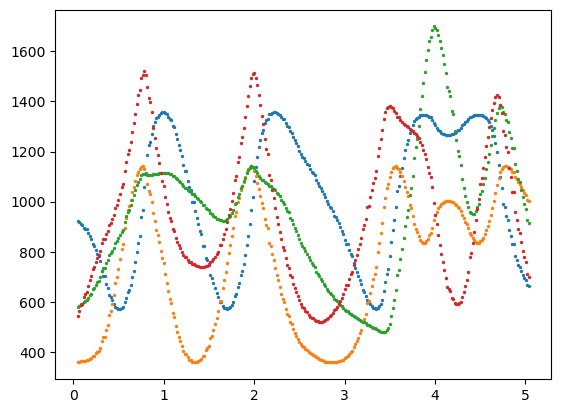

In [16]:
L=1  
smoothening_window_size = 15
pen_orig_len = abs(df_trimmed[0]["y_1"]).max()
#Scaling the pendulum length to L
for df_ in df_trimmed:
    df_["x_1"] = (df_["x_1"]/pen_orig_len) * L
    df_["y_1"] = (df_["y_1"]/pen_orig_len) * L
    df_["x_2"] = (df_["x_2"]/pen_orig_len) * L
    df_["y_2"] = (df_["y_2"]/pen_orig_len) * L

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    # df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    # df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:

    # df_[["x_1", "y_1", "x_2", "y_2"]][:100].plot()
    # for feat in ["x_1", "y_1", "x_2", "y_2"]:
    for feat in ["X1", "Y1", "X2", "Y2"]:
        plt.scatter(df_["t"][:300], df_[feat][:300], s=2)
        # plt.plot(df_["t"][:300], df_[feat][:300], ".-")

    # df_[["x_2", "y_2"]].plot()



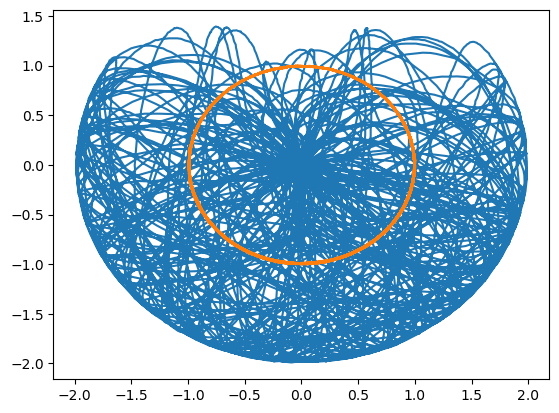

In [7]:
for df_ in df_trimmed:
    plt.plot(df_["x_2"], df_["y_2"])
    plt.plot(df_["x_1"], df_["y_1"])


## SVD analysis to track condition number

In [11]:
poly_degree = 5
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
data_matrix_df_new = df_appended[["x_1", "y_1", "x_2", "y_2"]]
data_matrix_df_new = data_matrix_df_new.sample(frac=1).reset_index(drop=True)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
feat_list = ["x_1","y_1", "x_2", "y_2"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

features_to_remove = {x_1**2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_1 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)


features_to_remove = {x_1**2, y_1*y_2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_2 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {x_1**2, y_1*y_2, y_2**2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_3 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

features_to_remove = {x_1**2, y_1*y_2, y_2**2, y_1*y_2}
# features_to_remove = {y**2, y*y_dot}
features_to_remove, refined_candid_lib_4 = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

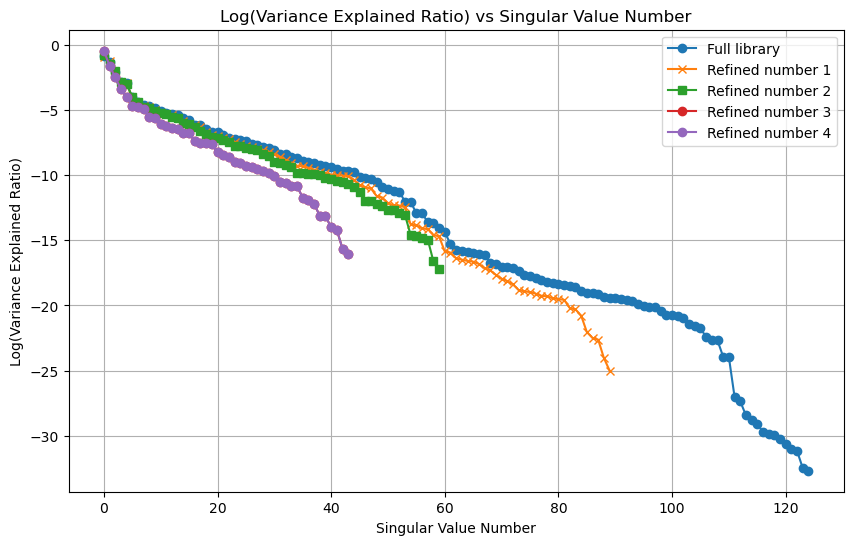

In [13]:
# Perform Singular Value Decomposition (SVD) on the candidate libraries
U_full, s_full, Vt_full = np.linalg.svd(candidate_lib_full, full_matrices=False)
U_refined_1, s_refined_1, Vt_refined_1 = np.linalg.svd(refined_candid_lib_1, full_matrices=False)
U_refined_2, s_refined_2, Vt_refined_2 = np.linalg.svd(refined_candid_lib_2, full_matrices=False)
U_refined_3, s_refined_3, Vt_refined_3 = np.linalg.svd(refined_candid_lib_3, full_matrices=False)
U_refined_4, s_refined_4, Vt_refined_4 = np.linalg.svd(refined_candid_lib_4, full_matrices=False)



# Calculate the explained variance ratio for the candidate libraries
explained_variance_ratio_full = (s_full ** 2) / np.sum(s_full ** 2)
explained_variance_ratio_refined_1 = (s_refined_1 ** 2) / np.sum(s_refined_1 ** 2)
explained_variance_ratio_refined_2 = (s_refined_2 ** 2) / np.sum(s_refined_2 ** 2)
explained_variance_ratio_refined_3 = (s_refined_3 ** 2) / np.sum(s_refined_3 ** 2)
explained_variance_ratio_refined_4 = (s_refined_4 ** 2) / np.sum(s_refined_4 ** 2)



# Plot the log of the explained variance ratio for all libraries
plt.figure(figsize=(10, 6))
plt.plot(np.log(explained_variance_ratio_full), marker='o', label='Full library')
plt.plot(np.log(explained_variance_ratio_refined_1), marker='x', label='Refined number 1')
plt.plot(np.log(explained_variance_ratio_refined_2), marker='s', label='Refined number 2')
plt.plot(np.log(explained_variance_ratio_refined_3), marker='o', label='Refined number 3')
plt.plot(np.log(explained_variance_ratio_refined_4), marker='o', label='Refined number 4')


plt.xlabel('Singular Value Number')
plt.ylabel('Log(Variance Explained Ratio)')
plt.title('Log(Variance Explained Ratio) vs Singular Value Number')
plt.legend()
plt.grid(True)

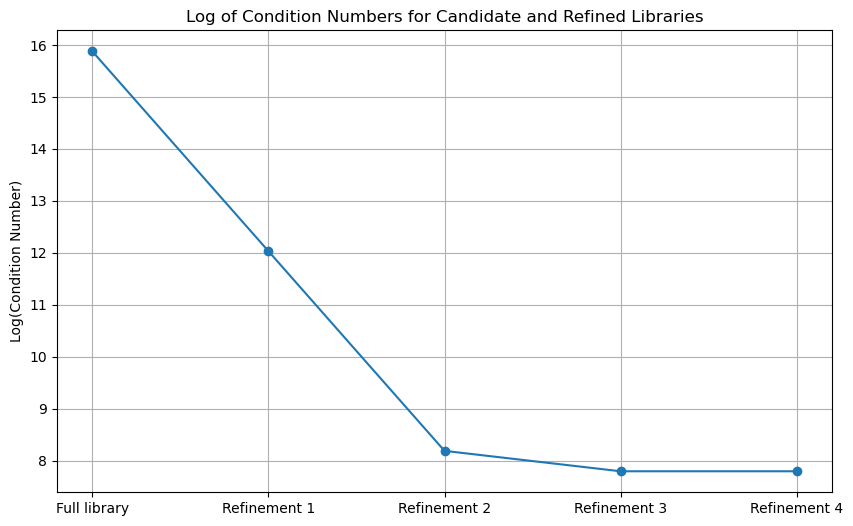

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the condition numbers
cond_numbers = [np.linalg.cond(lib) for lib in [candidate_lib_full, refined_candid_lib_1, refined_candid_lib_2,
                                                 refined_candid_lib_3, refined_candid_lib_4]]
# cond_num_full = np.linalg.cond(candidate_lib_full)
# cond_num_refined_1 = np.linalg.cond(refined_candid_lib_1)
# cond_num_refined_2 = np.linalg.cond(refined_candid_lib_2)
# cond_num_refined_3 = np.linalg.cond(refined_candid_lib_3)


# Plot the log of condition numbers
plt.figure(figsize=(10, 6))
plt.plot(["Full library","Refinement 1","Refinement 2", "Refinement 3", "Refinement 4"], np.log(cond_numbers), marker='o')
plt.ylabel('Log(Condition Number)')
plt.title('Log of Condition Numbers for Candidate and Refined Libraries')
plt.grid(True)
plt.show()
